In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # .experiments

Mounted at /content/gdrive


In [ ]:
import pickle
import scipy.signal
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def load_data(file_name):
    with open(f'/content/gdrive/My Drive/SSVEP_BR41N_IO/{file_name}.pickle', 'rb') as f:
        data = pickle.load(f)
        eegs, labels = data['eegs'], data['labels']
    return eegs, labels

def filter_eeg(eeg_signal):
    b1, a1 =scipy.signal.butter(N=6, Wn=[2, 30], btype='bandpass', fs=256)
    b2, a2 =scipy.signal.iirnotch(w0= 50, Q=30, fs=256)


    filtered_eeg = scipy.signal.filtfilt(b1, a1, eeg_signal)
    filtered_eeg2 = scipy.signal.filtfilt(b2, a2, filtered_eeg)
    return filtered_eeg2

In [ ]:
subject=1

eeg_run1, labels_run1 = load_data(f"data_sub{subject}_train1")
eeg_run2, labels_run2 = load_data(f"data_sub{subject}_train2")

In [ ]:
eeg_run1 = filter_eeg(eeg_run1)
eeg_run2 = filter_eeg(eeg_run2)

labels_run1= np.array(labels_run1)-1
labels_run2= np.array(labels_run2)-1

In [ ]:
def obtain_cwt(eeg_signals, n_freq=31):
    widths = np.arange(1, n_freq)
    eeg_cwt=[]
    for eeg_signal in eeg_signals:
        cwt_channels=[]
        for channel in eeg_signal:
            cwt_channels.append(signal.cwt(channel, signal.morle, widths))
        eeg_cwt.append(cwt_channels)
    return np.array(eeg_cwt)

In [ ]:
cwt_run1 = np.transpose(obtain_cwt(eeg_run1, 29), [0, 2, 3, 1])
cwt_run2 = np.transpose(obtain_cwt(eeg_run2, 29), [0, 2, 3, 1])

In [ ]:
eegs= eeg_run1
labels= labels_run1

eegs_1= eegs[np.where(labels==1)]
eegs_2= eegs[np.where(labels==2)]
eegs_3= eegs[np.where(labels==3)]
eegs_4= eegs[np.where(labels==4)]

cwt_1 = np.transpose(obtain_cwt(eegs_1, 100), [0, 2, 3, 1])
cwt_2 = np.transpose(obtain_cwt(eegs_2, 100), [0, 2, 3, 1])
cwt_3 = np.transpose(obtain_cwt(eegs_3, 100), [0, 2, 3, 1])
cwt_4 = np.transpose(obtain_cwt(eegs_4, 100), [0, 2, 3, 1])

In [ ]:
for channel in range(8):
    plt.imshow(np.abs(cwt_1[0,:,:,channel]))
    plt.show()

In [ ]:
for channel in range(8):
    plt.imshow(np.abs(cwt_2[0,:,:,channel]))
    plt.show()

In [ ]:
for channel in range(8):
    plt.imshow(np.abs(cwt_3[0,:,:,channel]))
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

def train_cnn_model(cwt_run1, labels_run1, cwt_run2=None, labels_run2=None, epochs=None, val_run2=False):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(cwt_run1.shape[1], cwt_run1.shape[2], cwt_run1.shape[3]))) # channel_last (cwt_run1.shape[3]= 8)
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    if not val_run2:
        history = model.fit(cwt_run1, labels_run1, epochs=epochs, validation_split=0.3)#,validation_data=test_dataset)
    else:
        history = model.fit(cwt_run1, labels_run1, epochs=epochs,validation_data=[cwt_run2, labels_run2])
    

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.show()

    return history

Epoch 1/25
2/2 [==============================] - 7s 3s/step - loss: 47.9283 - accuracy: 0.3170 - val_loss: 78.0374 - val_accuracy: 0.2500
Epoch 2/25
2/2 [==============================] - 6s 3s/step - loss: 71.7226 - accuracy: 0.2039 - val_loss: 20.6376 - val_accuracy: 0.2500
Epoch 3/25
2/2 [==============================] - 6s 3s/step - loss: 16.4327 - accuracy: 0.2827 - val_loss: 3.6618 - val_accuracy: 0.2083
Epoch 4/25
2/2 [==============================] - 6s 3s/step - loss: 2.8808 - accuracy: 0.3631 - val_loss: 2.3855 - val_accuracy: 0.2500
Epoch 5/25
2/2 [==============================] - 6s 3s/step - loss: 1.6072 - accuracy: 0.4226 - val_loss: 1.3983 - val_accuracy: 0.2500
Epoch 6/25
2/2 [==============================] - 6s 3s/step - loss: 1.1092 - accuracy: 0.6012 - val_loss: 1.3899 - val_accuracy: 0.3333
Epoch 7/25
2/2 [==============================] - 6s 3s/step - loss: 1.0806 - accuracy: 0.5580 - val_loss: 1.3743 - val_accuracy: 0.3750
Epoch 8/25
2/2 [====================

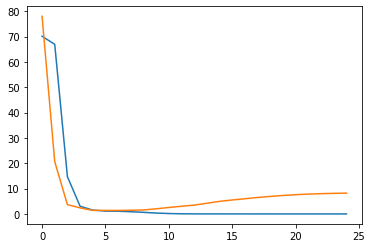

In [ ]:
hist = train_cnn_model(np.array(list(cwt_run1)+list(cwt_run2)), np.array(list(labels_run1)+list(labels_run2)), epochs= 25)

In [ ]:
hist = train_cnn_model(cwt_run1, labels_run1, epochs = 25)

In [ ]:
hist = train_cnn_model(cwt_run2, labels_run2, epochs = 25)

In [ ]:
train_cnn_model(cwt_run1, labels_run1, cwt_run2, labels_run2, epochs=25, val_run2=False)